<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/hair_styling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
project_path = '/content/drive/My Drive/hairy_gan/'
dataset_path = os.path.join(project_path, 'face_segment')
src_img_target_path = os.path.join(dataset_path, 'trainA')
label_img_target_path = os.path.join(dataset_path, 'trainB')

In [13]:
# move images and corresponding segmentation masks into their own folders
# tree = ET.parse(os.path.join(dataset_path, 'sampleset.xml'))
# root = tree.getroot()
# children = root.getchildren()
# for i in range(len(children) // 2):
#   src_img_path = children[2 * i].get('name').replace('\\', '/')
#   label_img_path = children[2 * i + 1].get('name').replace('\\', '/')
  
#   shutil.copy(os.path.join(dataset_path, src_img_path), os.path.join(src_img_target_path, os.path.basename(src_img_path)))
#   shutil.copy(os.path.join(dataset_path, label_img_path), os.path.join(label_img_target_path, os.path.basename(label_img_path)))

In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

!pip install pillow
!pip install scipy==1.1.0        

In [38]:
import xml.etree.ElementTree as ET
import shutil

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

import PIL
from glob import glob

import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [46]:
class DataLoader():
    def __init__(self, dataset_path, img_res=(128, 128)):
        self.dataset_path = dataset_path
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        # data_type = "train%s" % domain if not is_testing else "test%s" % domain
        data_type = 'train' + domain # always grab from training since we have no test
        path = glob(os.path.join(self.dataset_path, data_type, '*'))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob(os.path.join(self.dataset_path, data_type + 'A', '*'))
        path_B = glob(os.path.join(self.dataset_path, data_type + 'B', '*'))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        i = 0
        while True:
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            i += 1

            if i == self.n_batches - 1:
              path_A = np.random.choice(path_A, total_samples, replace=False)
              path_B = np.random.choice(path_B, total_samples, replace=False)
              i = 0
            yield imgs_A, imgs_B

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [49]:
class CycleGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)

    self.data_loader = DataLoader(dataset_path, img_res=(self.img_rows, self.img_cols))

    patch = int(self.img_rows / 2**4)
    self.disc_patch = (patch, patch, 1) # output shape of discriminator

    self.gf = 32 # num filters in first layer of gen
    self.df = 64 # num filters in first layer of disc

    self.lambda_cycle = 10.0
    self.lambda_id = 0.9 * self.lambda_cycle # identity loss weight

    optimizer = Adam(0.0002, 0.5)

  
    self.d_A = self.build_discriminator()
    self.d_B = self.build_discriminator()

    self.d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    self.d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    self.g_AB = self.build_generator()
    self.g_BA = self.build_generator()

    img_A = Input(shape=self.img_shape)
    img_B = Input(shape=self.img_shape)

    fake_B = self.g_AB(img_A)
    fake_A = self.g_BA(img_B)

    reconstr_A = self.g_BA(fake_B)
    reconstr_B = self.g_AB(fake_A)

    img_A_id = self.g_BA(img_A)
    img_B_id = self.g_AB(img_B)

    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)

    self.combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id])
    self.combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, self.lambda_cycle, self.lambda_cycle, self.lambda_id, self.lambda_id], optimizer=optimizer)


  def build_generator(self):
    '''U-net generator'''

    def conv2d(layer_input, filters, f_size=4):
      '''Layers used during downsampling'''
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      '''Layers used during upsampling'''
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)

      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])
      return u

    d0 = Input(shape=self.img_shape)
    d1 = conv2d(d0, self.gf)
    d2 = conv2d(d1, self.gf * 2)
    d3 = conv2d(d2, self.gf * 4)
    d4 = conv2d(d3, self.gf * 8)

    u1 = deconv2d(d4, d3, self.gf * 4)
    u2 = deconv2d(u1, d2, self.gf * 2)
    u3 = deconv2d(u2, d1, self.gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(self.img_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

  def build_discriminator(self):
    def d_layer(layer_input, filters, f_size=4, normalization=True):
      '''Discriminator Layer'''
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if normalization:
        d = InstanceNormalization()(d)
      return d

    img = Input(shape=self.img_shape)
    d1 = d_layer(img, self.df, normalization=False)
    d2 = d_layer(d1, self.df * 2)
    d3 = d_layer(d2, self.df * 4)
    d4 = d_layer(d3, self.df * 8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

  def train(self, epochs, batch_size=1, sample_interval=50):
    start_time = datetime.datetime.now()

    valid = np.ones((batch_size, ) + self.disc_patch)

    fake = np.zeros((batch_size, ) + self.disc_patch)

    for epoch in range(epochs):
      for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)

        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)

        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [fake, fake, imgs_A, imgs_B, imgs_A, imgs_B])

        if batch_i % sample_interval == 0:
          self.sample_images(epoch, batch_i)

          # save weights (cannot save model because eager behavior disabled)
          self.d_A.save_weights('d_A.weights')
          shutil.copy('d_A.weights', os.path.join(project_path, 'd_A.weights'))

          self.d_B.save_weights('d_B.weights')
          shutil.copy('d_B.weights', os.path.join(project_path, 'd_B.weights'))

          self.g_AB.save_weights('g_AB.weights')
          shutil.copy('g_AB.weights', os.path.join(project_path, 'g_AB.weights'))

          self.g_BA.save_weights('g_BA.weights')
          shutil.copy('g_BA.weights', os.path.join(project_path, 'g_BA.weights'))
  
  def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


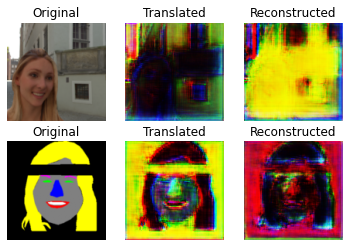

In [ ]:
gan = CycleGAN()
gan.train(epochs=100, batch_size=64, sample_interval=10)